In [1]:
import numpy as np
import scipy.io as sio
import cv2 as cv

import matplotlib as mlt
import matplotlib.pyplot as plt

In [121]:
path_indian_pines = '../MCRF_LVC/Data/Indian_Pines/'
path_paviauniversity = '../MCRF_LVC/Data/PaviaUniversity/'

In [122]:
indian_train = cv.imread(path_indian_pines + 'RawData/Train.bmp', -1)

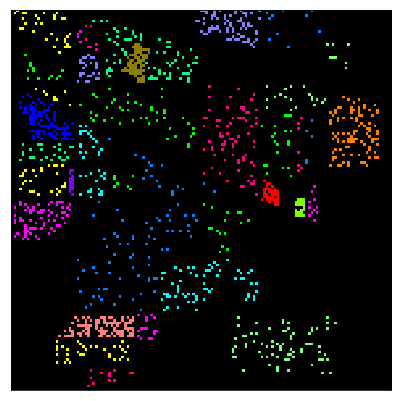

In [123]:
fig = plt.figure(figsize = (15, 7))

ax = fig.add_subplot(1, 1, 1)
ax.imshow(indian_train)
plt.xticks([])
plt.yticks([])

plt.show()

-------

# Functions Setup

In [5]:
def img2double(img):
    return np.asarray(img).astype(np.float64)/np.max(np.asarray(img))

In [6]:
def create_index_matrix(img):
    m, n = img.shape
    index_matrix = np.zeros((m, n))
    ind = 1
    
    for j in range(n):
        for i in range(m):
            if img[i, j] > 0:
                index_matrix[i , j] = ind
                ind += 1
            else:
                index_matrix[i, j] = -1
    
    return index_matrix, ind
    
    

In [7]:
def create_spatial_connectivity(img):
    m, n = cv.cvtColor(img, cv.COLOR_BGR2GRAY).shape
    index_matrix, ind = create_index_matrix(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    
    spatial_connectivity = np.zeros((3, ind - 1))
    
    for i in range(m):
        for j in range(n):
            if i-1 <= 0:
                spatial_connectivity[1, np.int(index_matrix[i,j]-1)] = -1
                spatial_connectivity[2, np.int(index_matrix[i,j]-1)] = -1
            else:
                spatial_connectivity[1, np.int(index_matrix[i,j]-1)] = index_matrix[i-1,j]
            
            if j-1 <= 0:
                spatial_connectivity[0, np.int(index_matrix[i,j]-1)] = -1
                spatial_connectivity[2, np.int(index_matrix[i,j]-1)] = -1
            else:
                spatial_connectivity[0, np.int(index_matrix[i,j]-1)] = index_matrix[i, j-1]
                
            if (i-1 > 0) and (j-1 > 0):
                spatial_connectivity[2, np.int(index_matrix[i,j]-1)] = index_matrix[i-1, j-1]
                
    return spatial_connectivity

In [8]:
def create_bin_file(data, filename):
    with open(filename + '.bin', 'wb') as f:
#         f.write(data)
        data.tofile(f)
    f.close()
            
    return '--- Bin File created ---'

In [9]:
spatial_connectivity = create_spatial_connectivity(indian_train)

In [10]:
create_bin_file(spatial_connectivity, '01_SpatialConnectivity1')

'--- Bin File created ---'

In [11]:
indian = sio.loadmat(path_indian_pines + '/RawData/Image.mat')

In [124]:
indian_img = indian['Data']

In [125]:
indian_img.shape

(145, 145, 200)

# PCA

In [113]:
def normalize(mat):
    mat -= np.min(mat)
    mat /= np.ptp(mat)
    return mat

In [127]:
def img_pca(img):
    m, n, l = img.shape
    img = img.reshape(-1, l)
    
    img = img2double(img)
    img_cov = np.cov(img.T)
    
    img_std = np.transpose([np.sqrt(np.diag(img_cov))])
    img_std = std @ std.T
    img_cov = img_cov / img_std
    
    eigen_values, eigen_vectors = np.linalg.eig(img_cov)
    
    select_dim = np.where(eigen_values >= 1)
    
    y = (eigen_vectors @ img.T).T
    y = y[:,select_dim[0]]
    
    y = normalize(y.T).astype(np.uint16)
    
    return y
    

In [131]:
indian_img_pca = img_pca(indian_img)

In [132]:
indian_img_pca.shape

(13, 21025)

In [143]:
create_bin_file(indian_img_pca, '01_30_{}_Features2'.format(indian_img_pca.shape[0]))

'--- Bin File created ---'